<a href="https://colab.research.google.com/github/harshit-046/ai-project/blob/main/Forcasting_bitcoin_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup and Data Acquisition**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:
DATA_SOURCE = "yfinance"
TICKER = "BTC-USD"
START_DATE = "2016-03-01"
END_DATE = "2021-02-27" # (Paper says 26-02, but yfinance end dates are exclusive, so we add one day)
TRAIN_SPLIT_PERCENT = 0.8  # 80% for training
TIME_STEP = 60

In [ ]:
print(f"Downloading data for {TICKER} from {START_DATE} to {END_DATE}...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

/tmp/ipython-input-3859939632.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [ ]:
print("\n--- Data Head ---")
print(df.head())
print("\n--- Data Info ---")
df.info()

# Check for NULL values, as mentioned in the paper [cite: 139]
print(f"\nNull values found: {df.isnull().sum().sum()}")


--- Data Head ---
Price            Close        High         Low        Open     Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD    BTC-USD
Date                                                                 
2016-03-01  435.122986  439.653015  432.319000  437.916992   74895800
2016-03-02  423.989014  435.916992  423.989014  435.131012   74955296
2016-03-03  421.651001  425.372986  419.411011  423.911987  100484000
2016-03-04  410.938995  425.178009  410.938995  421.835999   90856096
2016-03-05  400.570007  411.256989  394.035004  410.781006  135384992

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2016-03-01 to 2021-02-26
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1824 non-null   float64
 1   (High, BTC-USD)    1824 non-null   float64
 2   (Low, BTC-USD)     1824 non-null   float64
 3   (Open, BTC-USD)    1824 non-null 

**Data Preprocessing**

In [ ]:
# The paper mentions removing rows with NULL values [cite: 139]
df.dropna(inplace=True)

In [ ]:
# Let's check the exact column names in your DataFrame
print("--- Available Columns in df ---")
print(df.columns)
print("\n")

# We will use df[['Close']] which is the standard way to select a
# column and keep it as a DataFrame.
# If your column name is different (e.g., 'close'), change it here.
try:
    data = df[['Close']]
except KeyError:
    print("ERROR: The column 'Close' was not found in your DataFrame.")
    print("Please check the 'Available Columns' printed above and correct the column name.")
    # Stop execution if the column isn't found
    raise

dataset = data.values  # Convert to numpy array

# This shape should now be (1824, 1) or similar, not (1824, 0)
print(f"Shape of dataset before scaling: {dataset.shape}")

if dataset.shape[1] == 0:
    print("ERROR: The dataset is still empty. Please check your 'df' DataFrame.")
else:
    # The paper uses MinMaxScaler to scale data between 0 and 1 [cite: 141]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    print("--- Data Scaled Successfully ---")

    # The paper used 80% for training and 20% for testing [cite: 145]
    training_data_len = int(np.ceil(len(dataset) * TRAIN_SPLIT_PERCENT))
    train_data = scaled_data[0:int(training_data_len), :]
    test_data = scaled_data[training_data_len - TIME_STEP:, :] # [cite: 145]

    print(f"Training data length: {len(train_data)}")
    print(f"Test data length: {len(test_data)}")

--- Available Columns in df ---
MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


Shape of dataset before scaling: (1824, 1)
--- Data Scaled Successfully ---
Training data length: 1460
Test data length: 424


In [ ]:
# This function converts an array of values into a dataset of
# sequences (X) and their corresponding next value (y)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Create training and testing sequences
x_train, y_train = create_dataset(train_data, TIME_STEP)
x_test, y_test = create_dataset(test_data, TIME_STEP)

In [ ]:
# The LSTM model expects 3 dimensions: [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"\nTraining data shape (X, y): {x_train.shape}, {y_train.shape}")
print(f"Testing data shape (X, y): {x_test.shape}, {y_test.shape}")


Training data shape (X, y): (1400, 60, 1), (1400,)
Testing data shape (X, y): (364, 60, 1), (364,)


**Model Building and Training**

In [ ]:
# This function creates the correct model architecture based on the loop
def build_model(model_name, neurons, time_step):
    model = Sequential()

    # Get the input shape from our training data
    input_shape = (time_step, 1)

    if model_name == 'LSTM':
        # Paper's proposed model [cite: 74, 153]
        model.add(LSTM(neurons, activation='tanh', input_shape=input_shape))

    elif model_name == 'Bi-LSTM':
        # Bi-Directional LSTM [cite: 182]
        model.add(Bidirectional(
            LSTM(neurons, activation='tanh'),
            input_shape=input_shape
        ))

    elif model_name == 'GRU':
        # Gated Recurrent Unit [cite: 188]
        model.add(GRU(neurons, activation='tanh', input_shape=input_shape))

    # All models have the same output layer [cite: 149, 299]
    model.add(Dense(1, activation='linear'))

    # Compile the model as specified in the paper [cite: 151, 302]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mae')

    return model

In [ ]:
model_types = ['LSTM', 'Bi-LSTM', 'GRU']
neuron_counts = [25, 50, 75, 100, 125, 150]
results_list = [] # To store our data for the table

In [ ]:
print("--- Starting Full Experiment Replication (18 models) ---")
print("This will take a significant amount of time.")

for model_name in model_types:
    for neurons in neuron_counts:

        print(f"\n--- Training: {model_name} with {neurons} neurons ---")

        # Build the model
        model = build_model(model_name, neurons, TIME_STEP)

        # Train the model [cite: 152]
        model.fit(
            x_train,
            y_train,
            batch_size=72,
            epochs=50,
            validation_data=(x_test, y_test),
            verbose=1  # Set to 1 to see progress for every epoch
        )

        # Make predictions
        predictions_scaled = model.predict(x_test)

        # De-normalize
        predictions = scaler.inverse_transform(predictions_scaled)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate all four metrics
        mae = mean_absolute_error(y_test_actual, predictions)
        mse = mean_squared_error(y_test_actual, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_actual, predictions)

        print(f"Results for {model_name}-{neurons}:")
        print(f"  MAE:  {mae:.4f}")
        print(f"  MSE:  {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R2:   {r2:.4f}")

        # Store results
        results_list.append({
            "Model": model_name,
            "Neurons": neurons,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2
        })

print("\n--- Full Experiment Complete ---")

--- Starting Full Experiment Replication (18 models) ---
This will take a significant amount of time.

--- Training: LSTM with 25 neurons ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0576 - val_loss: 0.0914
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0199 - val_loss: 0.0249
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0270
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - val_loss: 0.0251
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0241
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0068 - val_loss: 0.0242
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - val_loss: 0.0233
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0239
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0226
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - val_loss: 0.0213
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0666 - val_loss: 0.0831
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0168 - val_loss: 0.0292
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - val_loss: 0.0199
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076 - val_loss: 0.0209
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0210
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0193
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0201
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - val_loss: 0.0184
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - val_loss: 0.0209
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - val_loss: 0.0230
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0212
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0468 - val_loss: 0.0227
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0102 - val_loss: 0.0187
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0078 - val_loss: 0.0177
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0176
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 0.0180
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0188
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0197
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0183
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - val_loss: 0.0181
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 - val_loss: 0.0202
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056 - val_loss: 0.0191
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0463 - val_loss: 0.0218
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0108 - val_loss: 0.0175
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0172
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0175
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0057 - val_loss: 0.0165
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0164
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0159
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0053 - val_loss: 0.0171
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0175
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0052 - val_loss: 0.0160
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0153
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0538 - val_loss: 0.0266
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097 - val_loss: 0.0240
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0256
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 0.0183
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063 - val_loss: 0.0205
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0060 - val_loss: 0.0198
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0190
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0175
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0188
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0169
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0246
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0453 - val_loss: 0.0200
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0075 - val_loss: 0.0197
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0182
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0188
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0058 - val_loss: 0.0215
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058 - val_loss: 0.0206
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0213
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - val_loss: 0.0174
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0172
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0168
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0200
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0766 - val_loss: 0.1020
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0228 - val_loss: 0.0237
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0226
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087 - val_loss: 0.0220
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0083 - val_loss: 0.0223
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0225
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0249
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0223
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_loss: 0.0260
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - val_loss: 0.0251
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0067 - val_loss: 0.0258
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0711 - val_loss: 0.1172
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0197 - val_loss: 0.0361
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0120 - val_loss: 0.0283
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0088 - val_loss: 0.0216
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0079 - val_loss: 0.0192
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - val_loss: 0.0193
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - val_loss: 0.0193
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0063 - val_loss: 0.0206
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - val_loss: 0.0246
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062 - val_loss: 0.0228
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0057 - val_loss: 0.0287
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0056 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0475 - val_loss: 0.0424
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0154 - val_loss: 0.0351
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0101 - val_loss: 0.0204
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - val_loss: 0.0218
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0078 - val_loss: 0.0176
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0228
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_loss: 0.0184
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - val_loss: 0.0174
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058 - val_loss: 0.0199
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0169
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0072 - val_loss: 0.0200
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0589 - val_loss: 0.0408
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0174 - val_loss: 0.0323
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0109 - val_loss: 0.0219
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0079 - val_loss: 0.0224
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071 - val_loss: 0.0182
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0068 - val_loss: 0.0178
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - val_loss: 0.0289
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0065 - val_loss: 0.0225
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0068 - val_loss: 0.0196
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0243
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - val_loss: 0.0194
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0055 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0403 - val_loss: 0.0483
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0143 - val_loss: 0.0237
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0093 - val_loss: 0.0296
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0078 - val_loss: 0.0175
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0070 - val_loss: 0.0164
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064 - val_loss: 0.0203
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0063 - val_loss: 0.0177
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - val_loss: 0.0157
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056 - val_loss: 0.0164
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - val_loss: 0.0171
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061 - val_loss: 0.0200
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0457 - val_loss: 0.0402
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0136 - val_loss: 0.0244
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0088 - val_loss: 0.0189
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - val_loss: 0.0178
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0066 - val_loss: 0.0178
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0217
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063 - val_loss: 0.0259
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0064 - val_loss: 0.0234
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - val_loss: 0.0258
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0059 - val_loss: 0.0198
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - val_loss: 0.0229
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0445 - val_loss: 0.0927
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0205 - val_loss: 0.0144
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0149
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0116
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - val_loss: 0.0117
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0121
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0142
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - val_loss: 0.0121
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - val_loss: 0.0109
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039 - val_loss: 0.0107
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0104
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - val_loss: 0.0

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0538 - val_loss: 0.0745
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0130 - val_loss: 0.0144
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0069 - val_loss: 0.0129
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0121
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - val_loss: 0.0128
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0123
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0121
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0125
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0040 - val_loss: 0.0123
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0161
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0036 - val_los

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0449 - val_loss: 0.0182
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0094 - val_loss: 0.0174
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061 - val_loss: 0.0129
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0132
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 0.0124
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0128
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0043 - val_loss: 0.0111
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - val_loss: 0.0109
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0042 - val_loss: 0.0109
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0116
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0535 - val_loss: 0.0357
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0100 - val_loss: 0.0206
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064 - val_loss: 0.0201
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067 - val_loss: 0.0131
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0121
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0047 - val_loss: 0.0127
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0114
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0115
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040 - val_loss: 0.0111
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0044 - val_loss: 0.0121
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0532 - val_loss: 0.0206
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0090 - val_loss: 0.0188
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0055 - val_loss: 0.0131
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044 - val_loss: 0.0161
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0151
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054 - val_loss: 0.0121
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0124
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045 - val_loss: 0.0112
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046 - val_loss: 0.0111
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0039 - val_loss: 0.0112
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_l

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0435 - val_loss: 0.0158
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0083 - val_loss: 0.0130
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056 - val_loss: 0.0125
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - val_loss: 0.0167
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0117
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0108
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - val_loss: 0.0115
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0126
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0113
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042 - val_loss: 0.0115
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036 - val_loss: 0.0112
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037 - val_l

**Evaluation and Visualization**

In [ ]:
results_df = pd.DataFrame(results_list)

print("\n--- Detailed Comparison Table (Replication of Table I) ---")
print(results_df.to_string()) # .to_string() prints the full table


--- Detailed Comparison Table (Replication of Table I) ---
      Model  Neurons          MAE           MSE         RMSE        R2
0      LSTM       25   870.393250  2.756987e+06  1660.417753  0.979431
1      LSTM       50   944.292291  3.234211e+06  1798.391160  0.975870
2      LSTM       75   894.090413  2.783019e+06  1668.238391  0.979236
3      LSTM      100   893.713321  2.594249e+06  1610.667166  0.980645
4      LSTM      125   659.597809  1.631226e+06  1277.194494  0.987830
5      LSTM      150   645.400146  1.679200e+06  1295.839396  0.987472
6   Bi-LSTM       25  1041.979947  4.277734e+06  2068.268367  0.968085
7   Bi-LSTM       50  1093.766741  5.136238e+06  2266.326906  0.961680
8   Bi-LSTM       75   778.693614  2.382631e+06  1543.577216  0.982224
9   Bi-LSTM      100   884.106133  3.094626e+06  1759.155014  0.976912
10  Bi-LSTM      125   731.546497  2.265947e+06  1505.306377  0.983094
11  Bi-LSTM      150   652.816606  1.698210e+06  1303.153853  0.987330
12      GRU      

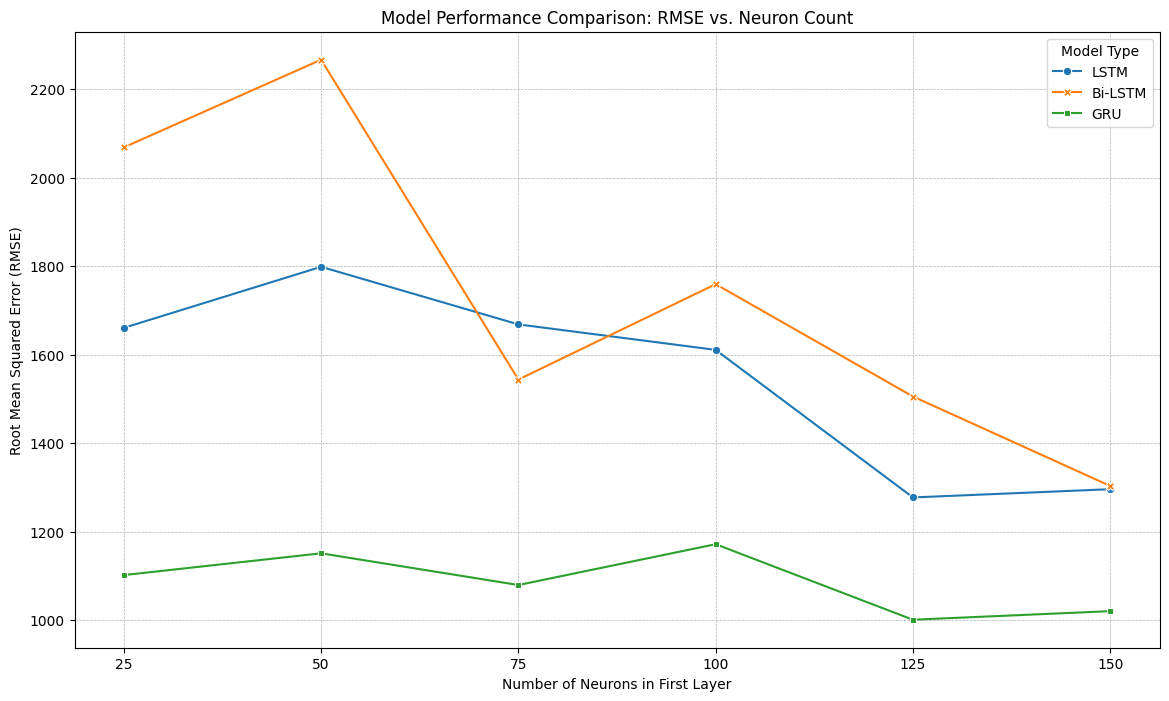

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn makes attractive plots

plt.figure(figsize=(14, 8))
sns.lineplot(
    data=results_df,
    x='Neurons',
    y='RMSE',
    hue='Model',
    style='Model',
    markers=True,
    dashes=False
)
plt.title('Model Performance Comparison: RMSE vs. Neuron Count')
plt.xlabel('Number of Neurons in First Layer')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(neuron_counts) #
plt.legend(title='Model Type')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

--- Found Best Configurations ---
Best LSTM:   125 neurons (RMSE: 1277.1945)
Best Bi-LSTM: 150 neurons (RMSE: 1303.1539)
Best GRU:    125 neurons (RMSE: 1000.8893)

--- Generating plots for: LSTM with 125 neurons ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


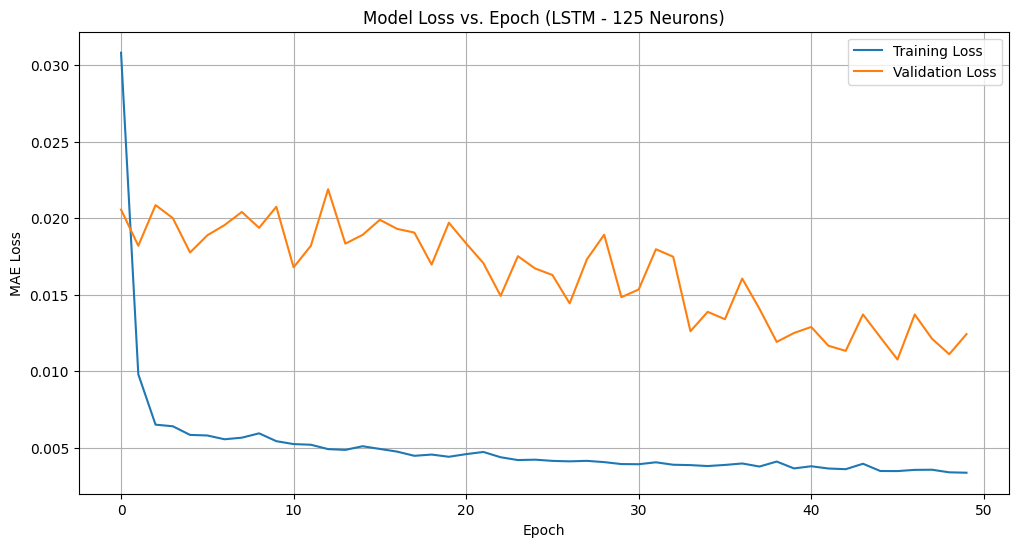

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/tmp/ipython-input-4113545360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


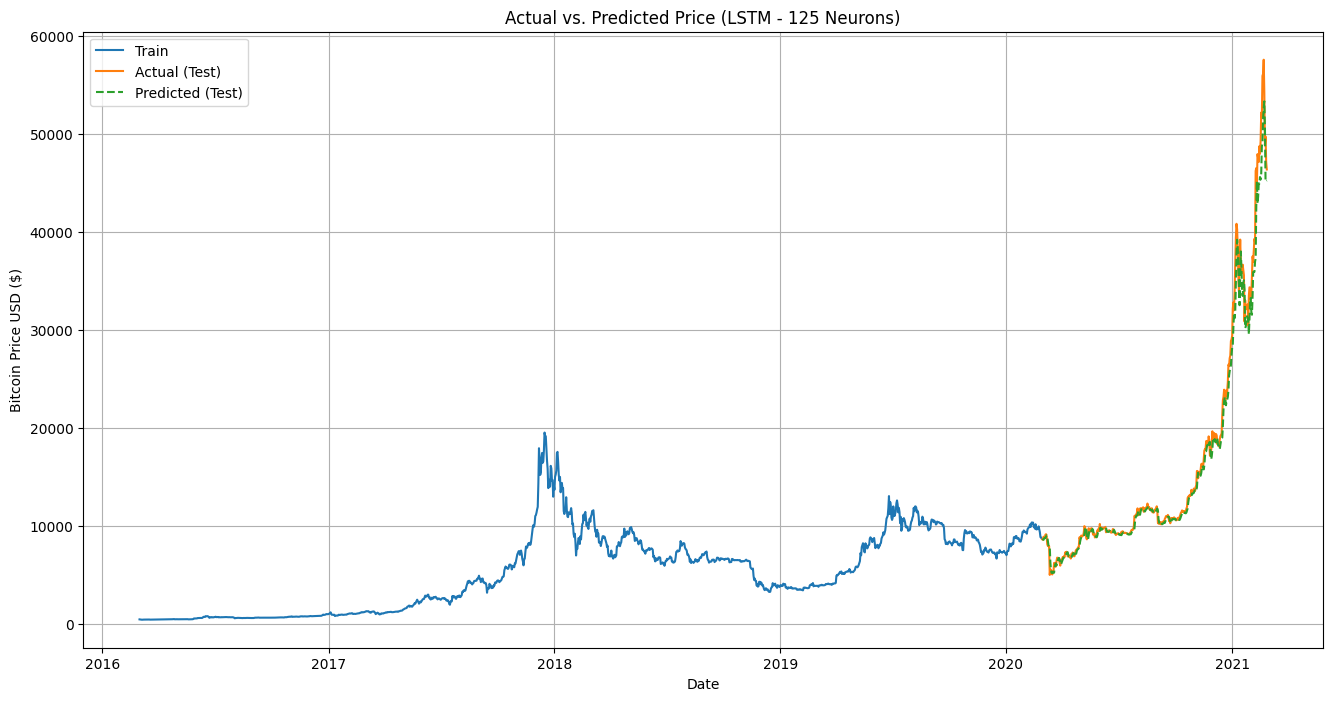


--- Generating plots for: Bi-LSTM with 150 neurons ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


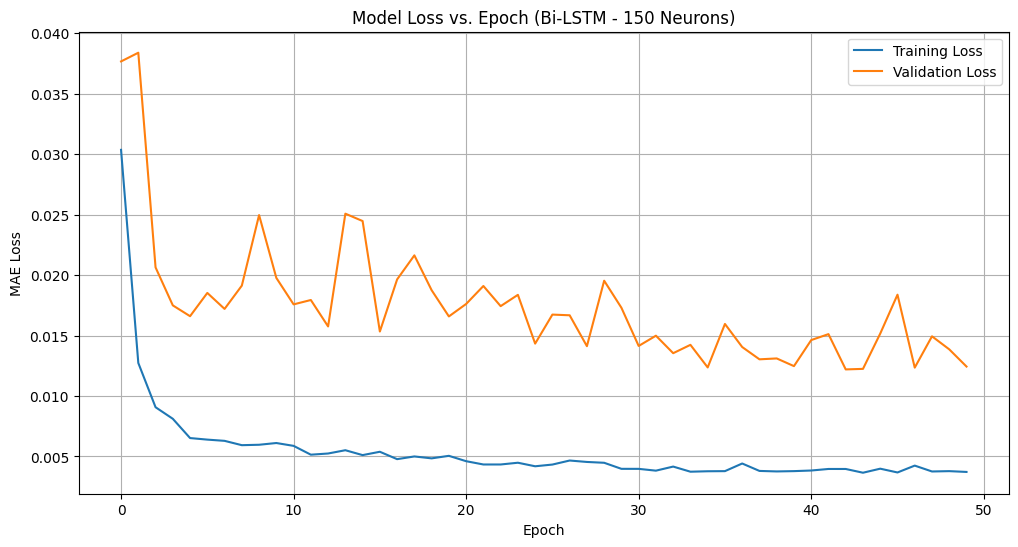

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/tmp/ipython-input-4113545360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


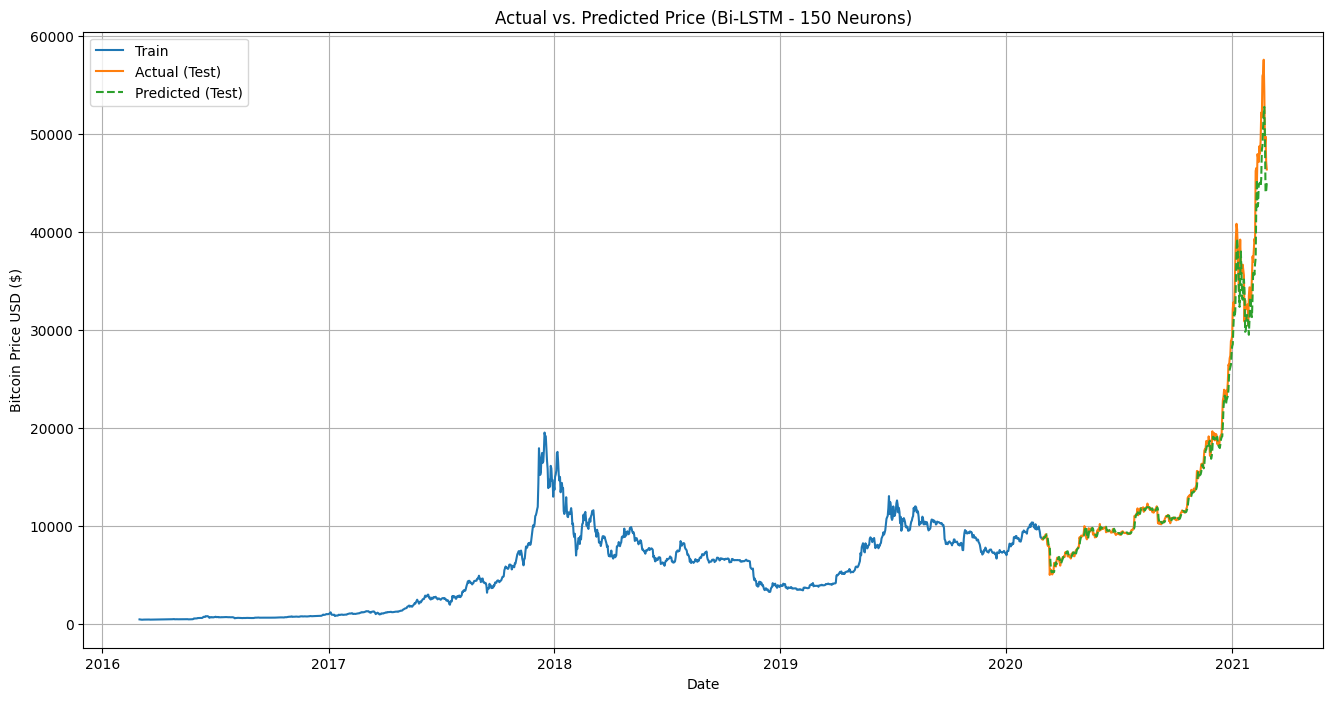


--- Generating plots for: GRU with 125 neurons ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


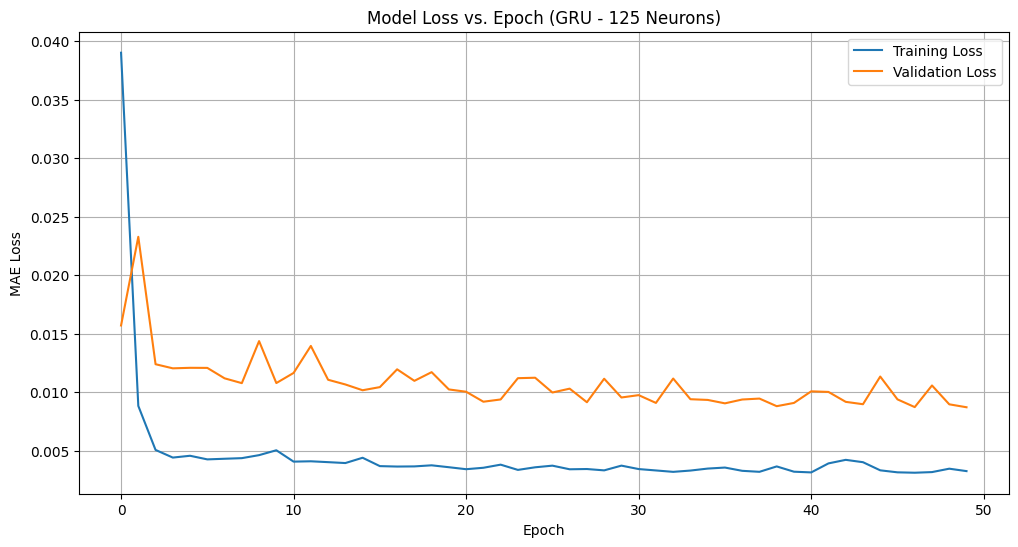

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/tmp/ipython-input-4113545360.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


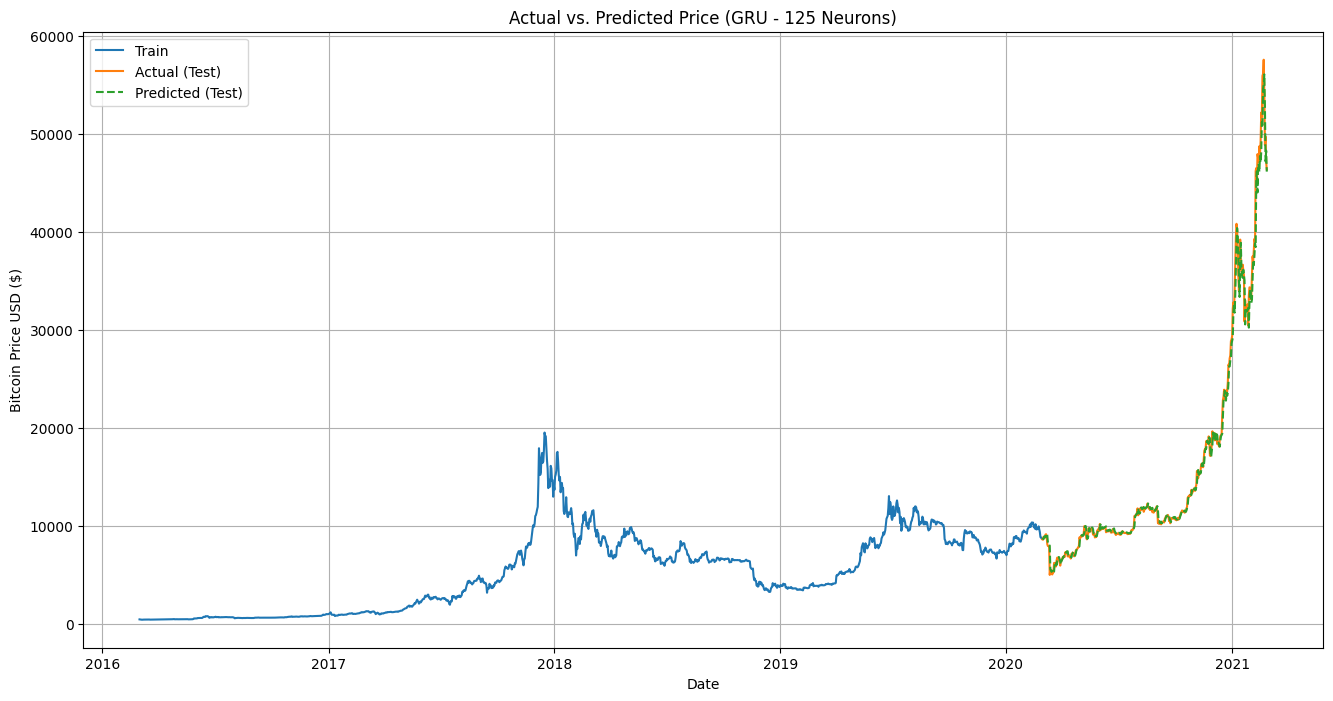

--- Detailed Plot Generation Complete ---


In [ ]:
# We use .loc and .idxmin() to find the row with the lowest RMSE for each model
best_lstm_config = results_df.loc[results_df[results_df['Model'] == 'LSTM']['RMSE'].idxmin()]
best_bilstm_config = results_df.loc[results_df[results_df['Model'] == 'Bi-LSTM']['RMSE'].idxmin()]
best_gru_config = results_df.loc[results_df[results_df['Model'] == 'GRU']['RMSE'].idxmin()]

best_configs = [best_lstm_config, best_bilstm_config, best_gru_config]

print("--- Found Best Configurations ---")
print(f"Best LSTM:   {int(best_lstm_config['Neurons'])} neurons (RMSE: {best_lstm_config['RMSE']:.4f})")
print(f"Best Bi-LSTM: {int(best_bilstm_config['Neurons'])} neurons (RMSE: {best_bilstm_config['RMSE']:.4f})")
print(f"Best GRU:    {int(best_gru_config['Neurons'])} neurons (RMSE: {best_gru_config['RMSE']:.4f})")


for config in best_configs:
    model_name = config['Model']
    neurons = int(config['Neurons'])

    print(f"\n--- Generating plots for: {model_name} with {neurons} neurons ---")

    model = build_model(model_name, neurons, TIME_STEP)

    history = model.fit(
        x_train,
        y_train,
        batch_size=72,
        epochs=50,
        validation_data=(x_test, y_test),
        verbose=0
    )

    # Loss vs. Epoch
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss vs. Epoch ({model_name} - {neurons} Neurons)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Make predictions for the second plot
    predictions_scaled = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    # Prepare data for plotting
    train_plot = data[:training_data_len]
    valid_plot = data[training_data_len:]
    valid_plot['Predictions'] = predictions

    # PLOT 2: Price vs. Days
    plt.figure(figsize=(16, 8))
    plt.title(f'Actual vs. Predicted Price ({model_name} - {neurons} Neurons)')
    plt.xlabel('Date')
    plt.ylabel('Bitcoin Price USD ($)')
    plt.plot(train_plot['Close'], label='Train')
    plt.plot(valid_plot['Close'], label='Actual (Test)')
    plt.plot(valid_plot['Predictions'], label='Predicted (Test)', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()


print("--- Detailed Plot Generation Complete ---")


--- The best overall model is: GRU with 125 neurons ---
  Best RMSE: 1000.8893
Re-training the best model for final visualization...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/tmp/ipython-input-3521917883.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = predictions


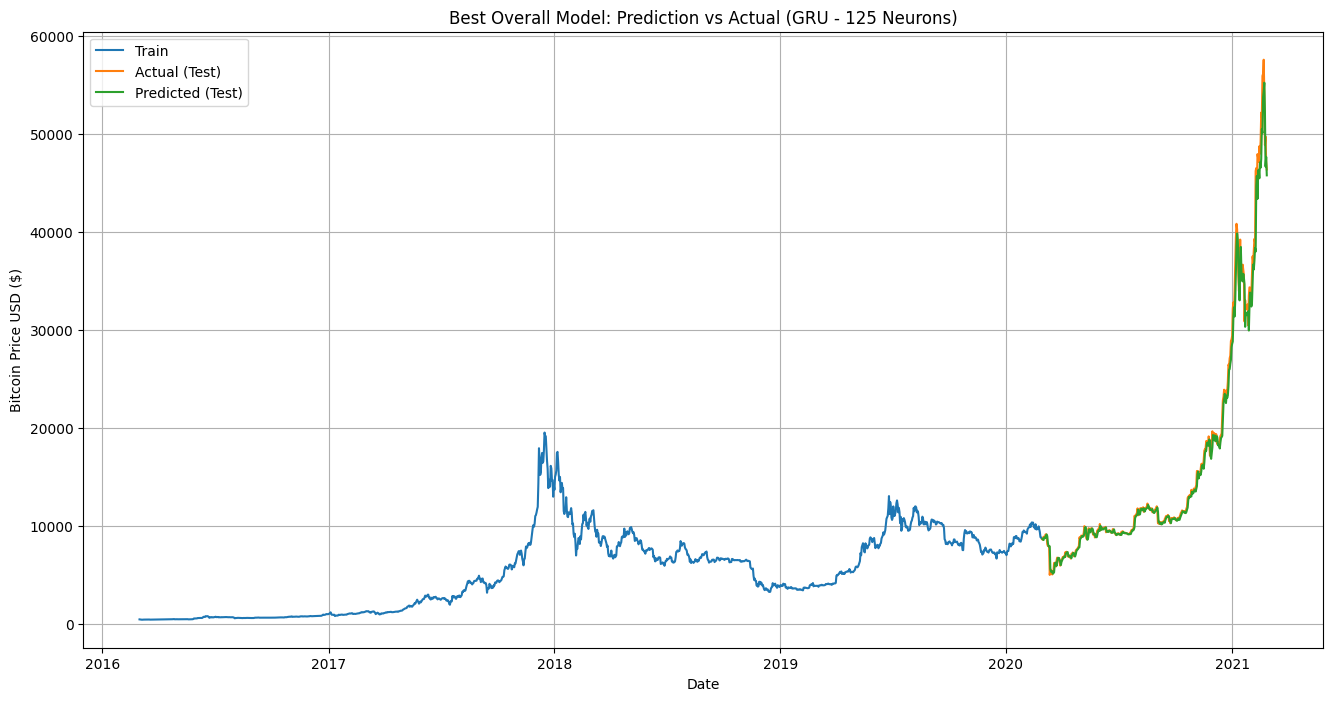

In [ ]:
best_result = results_df.loc[results_df['RMSE'].idxmin()]
best_model_name = best_result['Model']
best_neurons = int(best_result['Neurons'])

print(f"\n--- The best overall model is: {best_model_name} with {best_neurons} neurons ---")
print(f"  Best RMSE: {best_result['RMSE']:.4f}")

print("Re-training the best model for final visualization...")
best_model = build_model(best_model_name, best_neurons, TIME_STEP)

best_model.fit(
    x_train,
    y_train,
    batch_size=72,
    epochs=50,
    verbose=0
)

predictions_scaled = best_model.predict(x_test)
predictions = scaler.inverse_transform(predictions_scaled)

# Create the dataframe for plotting
train_plot = data[:training_data_len]
valid_plot = data[training_data_len:]
valid_plot['Predictions'] = predictions

# Plot
plt.figure(figsize=(16, 8))
plt.title(f'Best Overall Model: Prediction vs Actual ({best_model_name} - {best_neurons} Neurons)')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price USD ($)')
plt.plot(train_plot['Close'], label='Train')
plt.plot(valid_plot['Close'], label='Actual (Test)')
plt.plot(valid_plot['Predictions'], label='Predicted (Test)')
plt.legend()
plt.grid(True)
plt.show()